In [13]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
import torch, torchvision, os, cv2
from torch.utils.data import random_split, Dataset
from torch.nn import Tanh, Linear, ReLU, Sequential, Conv2d, MaxPool2d, Sigmoid, BatchNorm2d, Flatten, ConvTranspose2d
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class augementData(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

def saveRes2Img(inputs, labels, outputs,saveImgPath):
    inputsNP = inputs.cpu().data.numpy()
    labelsNP = labels.cpu().data.numpy()
    outputsNP = outputs.cpu().data.numpy()
    rowN = 15
    for n in range(len(inputsNP)):
        ture_l = np.array(inputsNP[n,0,:,:])
        ture_a = np.array(labelsNP[n,0,:,:])
        ture_b = np.array(labelsNP[n,1,:,:])
        pred_a = np.array(outputsNP[n,0,:,:])
        pred_b = np.array(outputsNP[n,1,:,:])
        ture_LAB = np.array([ture_l,ture_a,ture_b])
        ture_LAB = ture_LAB*255
        pred_LAB = np.array([ture_l,pred_a,pred_b])
        pred_LAB = pred_LAB*255
        ture_LAB = np.moveaxis(ture_LAB, 0, -1) #Reshape channeL from  [C, H, W] to [H, W, C]
        pred_LAB = np.moveaxis(pred_LAB, 0, -1) #Reshape channeL from  [C, H, W] to [H, W, C]
        imgTrueRGB = cv2.cvtColor(np.uint8(ture_LAB), cv2.COLOR_LAB2RGB)
        imgPredRGB = cv2.cvtColor(np.uint8(pred_LAB), cv2.COLOR_LAB2RGB)
        imgGrayRGB = cv2.cvtColor(imgTrueRGB, cv2.COLOR_RGB2GRAY)
        if n == 0 or (n+1) % rowN == 1:
            imgTempTrue = imgTrueRGB
            imgTempPred = imgPredRGB
            imgTempGray = imgGrayRGB
        else:
            imgTempTrue = np.hstack((imgTempTrue, imgTrueRGB))
            imgTempPred = np.hstack((imgTempPred, imgPredRGB))
            imgTempGray = np.hstack((imgTempGray, imgGrayRGB))
        if (n+1) % rowN == 0:
            if n+1 == rowN:
                imgGroupTrue = imgTempTrue
                imgGroupPred = imgTempPred
                imgGroupGray = imgTempGray
            else:    
                imgGroupTrue = np.vstack((imgGroupTrue, imgTempTrue))
                imgGroupPred = np.vstack((imgGroupPred, imgTempPred))
                imgGroupGray = np.vstack((imgGroupGray, imgTempGray))
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupTrue)
    plt.axis('off')
    plt.savefig(saveImgPath+'TrueRes.png')
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupPred)
    plt.axis('off')
    plt.savefig(saveImgPath+'PredRes.png')
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupGray, cmap='gray')
    plt.axis('off')
    plt.savefig(saveImgPath+'GrayRes.png')

In [14]:
img_dir = "./face_images/"
_, _, files = next(os.walk(img_dir))
dataBGR = []
dataLAB = []
for f1 in files:
    img = cv2.imread(img_dir+f1)
    dataBGR.append(img)
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    dataLAB.append(imageLAB)
    
dataBGR = np.array(dataBGR, dtype = np.float32) #Change data type into float 32.
dataLAB = np.array(dataLAB, dtype = np.float32) #Change data type into float 32.

In [15]:
# Image data types and what they mean!!!
# https://scikit-image.org/docs/dev/user_guide/data_types.html
# Data type
# Range
# uint8
# 0 to 255
# uint16
# 0 to 65535
# uint32
# 0 to 232 - 1
# float
# -1 to 1 or 0 to 1
# int8
# -128 to 127
# int16
# -32768 to 32767
# int32
# -231 to 231 - 1

#According to openCV documents, the range of L*, B*, C* in openCV are expressed as:
#Articel ource https://rodrigoberriel.com/2014/11/opencv-color-spaces-splitting-channels/#:~:text=The%20Lab%20ranges%20are%3A,(1%20%3E%20L%20%3E%20255)
#0 > L > 100 ⇒ OpenCV range = L*255/100 (1 > L > 255)
#-127 > a > 127 ⇒ OpenCV range = a + 128 (1 > a > 255)
#-127 > b > 127 ⇒ OpenCV range = b + 128 (1 > b > 255)

dataLAB = dataLAB / 255 ##Change reange into [0, 1]
dataLAB = np.moveaxis(dataLAB, -1, 1) #Reshape channeL from [B, H, W, C] to [B, C, H, W]
dataLAB = dataLAB[torch.randperm(dataLAB.shape[0],generator=torch.random.manual_seed(42))] #shuffle with random seed 42 to make sure each round with same samples pool.
lengths = [int(len(dataLAB)*0.9), int(len(dataLAB)*0.1)]
trainLAB, testLAB = random_split(dataLAB, lengths ,generator=torch.random.manual_seed(42)) #Shuffle data with random seed 42 before split train and test
trainLAB = np.array(trainLAB)
testLAB = np.array(testLAB)

In [16]:
#%%time
trainLABTensor = torch.tensor(trainLAB)
trainLABTensorx10 = torch.clone(trainLABTensor)
for i in range(9):
    trainLABTensorx10 = torch.cat((trainLABTensorx10, torch.clone(trainLABTensor)), 0)
    
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop((128,128),scale=(0.6, 1.0)),
    torchvision.transforms.ToTensor()
])
trainLABTensorx10Aug = augementData(trainLABTensorx10,transform) #Augement train data.

trainData = [] 
trainLx10 = [] #Input L*
trainAx10 = [] #Matrix a* #Label
trainBx10 = [] #Matrix b* #Label
trainAvg_ax10 = [] #scalar mean a* #Label
trainAvg_bx10 = [] #scalar mean b* #Label
i = 0
for t in trainLABTensorx10Aug:
    meanA = torch.mean(t[1])
    meanB = torch.mean(t[2]) #trainLABTensorx10Aug[i,0,:,:]
    #print(np.array(trainLABTensorx10Aug[i,0,:,:]).shape)
    wh = len(t[0])
    trainData.append([torch.reshape(t[0], (1, wh, wh)), torch.tensor([meanA, meanB]), 
                      torch.tensor([np.array(t[1]), np.array(t[2])])])
    trainLx10.append(t[0])
    trainAx10.append(t[1])
    trainBx10.append(t[2])
    trainAvg_ax10.append(meanA)
    trainAvg_bx10.append(meanB)
    i+=1
trainAvg_ax10, trainAvg_bx10 = np.array(trainAvg_ax10), np.array(trainAvg_bx10)     
trainlabelAvgABx10 = np.stack((trainAvg_ax10, trainAvg_bx10),axis=1)
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=100)

testDataL = testLAB[:,0,:,:] #Input L
testDataL = testDataL.reshape((testDataL.shape[0],1,testDataL.shape[1],testDataL.shape[2]))
testDataA = testLAB[:,1,:,:] #a* matrix
testDataA = testDataA.reshape((testDataA.shape[0],1,testDataA.shape[1],testDataA.shape[2]))
testDataB = testLAB[:,2,:,:] #b* matrix
testDataB = testDataB.reshape((testDataB.shape[0],1,testDataB.shape[1],testDataB.shape[2]))
testAvg_a = testLAB.mean(axis=(2,3))[:,1] #Get label mean of each a* 
testAvg_b = testLAB.mean(axis=(2,3))[:,2] #Get label mean of each b*
testDataL = torch.tensor(testDataL) #Test input
testlabelAvgAB = np.stack((testAvg_a, testAvg_b),axis=1)
testlabelAvgAB = torch.tensor(testlabelAvgAB) #Test output label

testData = []
for i in range(len(testDataL)):
    testData.append([testDataL[i], testlabelAvgAB[i], torch.tensor([testDataA[i][0], testDataB[i][0]])])
testLoader = torch.utils.data.DataLoader(testData, shuffle=False, batch_size=100)

In [17]:
netReg = Sequential(
            # Defining 1st 2D convolution layer
            Conv2d(1, 3, kernel_size=3, stride=1, padding=1), #128@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 2nd 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #64@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 3rd 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #32@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 4th 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #16@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 5th 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #8@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 6th 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #4@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 7th 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #2@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            #MaxPool2d(kernel_size=2, stride=2),
            Flatten(),
            Linear(3 * 2 * 2, 2)
        )

PATH = '../TrainedModel/RegCombWithLR0.1EP1000.pth'
netReg.load_state_dict(torch.load(PATH))
netReg = netReg.cuda()

In [18]:
#%%time
trainDataWithPredAB = []
for i, data in enumerate(trainLoader, 0):
    # get the inputs; data is a list of [inputs, labels]
    #inputs, labels = data[0].to(device), data[1].to(device)
    inputs, labelsAvgAB, labelsMatAB = data[0].cuda(), data[1].cuda(), data[2].cuda() #Reg
    predAvgAB = netReg(inputs)
    
    #trainDataWithPredAB.append([testDataL[i], testlabelAvgAB[i], torch.tensor([testDataA[i][0], testDataB[i][0]])])
    #print(inputs[0,0,1,1])
    inputsNP = inputs.cpu().data.numpy()
    labelsAvgAB = labelsAvgAB.cpu().data.numpy()
    labelsMatAB = labelsMatAB.cpu().data.numpy() 
    predAvgAB = predAvgAB.cpu().data.numpy() 
    
    w = inputsNP[0].shape[-2]
    h = inputsNP[0].shape[-1]
    for j in range(len(inputs)):
        predMatA = np.zeros((w,h)) + predAvgAB[j][0]
        predMatB = np.zeros((w,h)) + predAvgAB[j][1]
        trainDataWithPredAB.append([torch.tensor([inputsNP[j][0], predMatA, predMatB], dtype = torch.float32), 
                                    torch.tensor([labelsAvgAB[j][0], labelsAvgAB[j][1]], dtype = torch.float32), 
                                    torch.tensor([labelsMatAB[j][0], labelsMatAB[j][1]], dtype = torch.float32)])

trainLoaderWithPredAB = torch.utils.data.DataLoader(trainDataWithPredAB, shuffle=True, batch_size=100)        

testDataWithPredAB = []
for i, data in enumerate(testLoader, 0):
    # get the inputs; data is a list of [inputs, labels]
    #inputs, labels = data[0].to(device), data[1].to(device)
    inputs, labelsAvgAB, labelsMatAB = data[0].cuda(), data[1].cuda(), data[2].cuda()
    predAvgAB = netReg(inputs)
    
    #trainDataWithPredAB.append([testDataL[i], testlabelAvgAB[i], torch.tensor([testDataA[i][0], testDataB[i][0]])])
    #print(inputs[0,0,1,1])
    inputsNP = inputs.cpu().data.numpy()
    labelsAvgAB = labelsAvgAB.cpu().data.numpy()
    labelsMatAB = labelsMatAB.cpu().data.numpy() 
    predAvgAB = predAvgAB.cpu().data.numpy() 
    
    w = inputsNP[0].shape[-2]
    h = inputsNP[0].shape[-1]
    for j in range(len(inputs)):
        predMatA = np.zeros((w,h)) + predAvgAB[j][0]
        predMatB = np.zeros((w,h)) + predAvgAB[j][1]
        testDataWithPredAB.append([torch.tensor([inputsNP[j][0], predMatA, predMatB], dtype = torch.float32), 
                                    torch.tensor([labelsAvgAB[j][0], labelsAvgAB[j][1]], dtype = torch.float32), 
                                    torch.tensor([labelsMatAB[j][0], labelsMatAB[j][1]], dtype = torch.float32)])
#torch.tensor(np.array([inputsNP[j][0],predMatA,predMatB]))
testLoaderWithPredAB = torch.utils.data.DataLoader(testDataWithPredAB, shuffle=False, batch_size=100)  

In [21]:
#ColorizingCombWithLR0.1EP1000
netClo = Sequential(
            # Defining 1st 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #128@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 2nd 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #64@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 3rd 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #32@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 4th 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #16@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            ConvTranspose2d(3, 3, 4, stride=2, padding=1), #@16@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            ConvTranspose2d(3, 3, 4, stride=2, padding=1), #@32@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            ConvTranspose2d(3, 3, 4, stride=2, padding=1), #@64@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            ConvTranspose2d(3, 2, 4, stride=2, padding=1), #@128@3
            Sigmoid()
        )

PATH = '../TrainedModel/ColorizingCombWithLR0.1EP1000.pth'
netClo.load_state_dict(torch.load(PATH))
netClo = netClo.cuda()
criterion = nn.MSELoss()

Train MSE_Loss: 0.0003028092


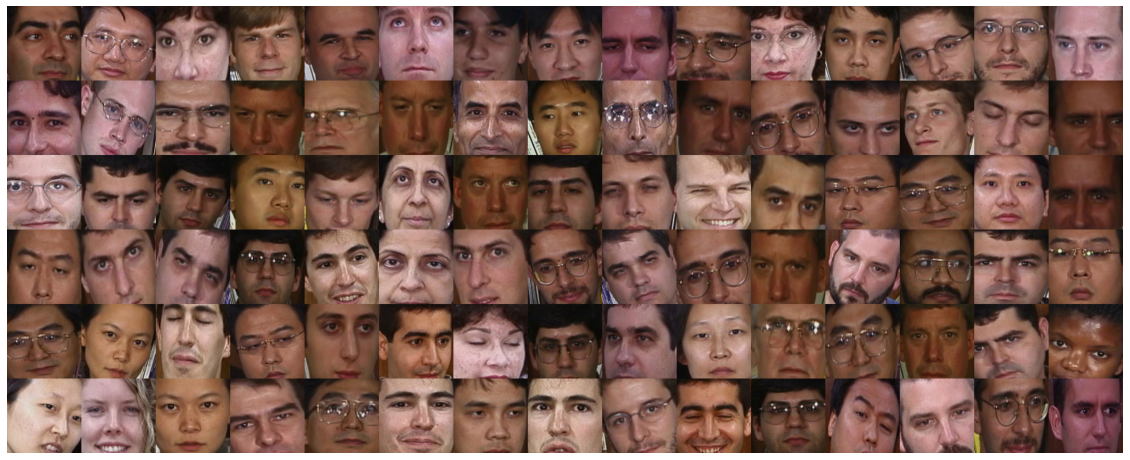

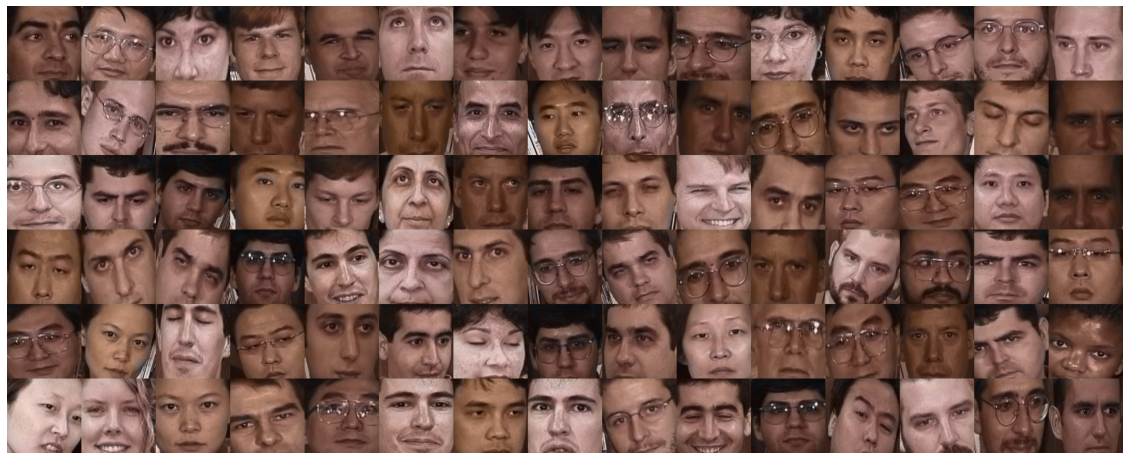

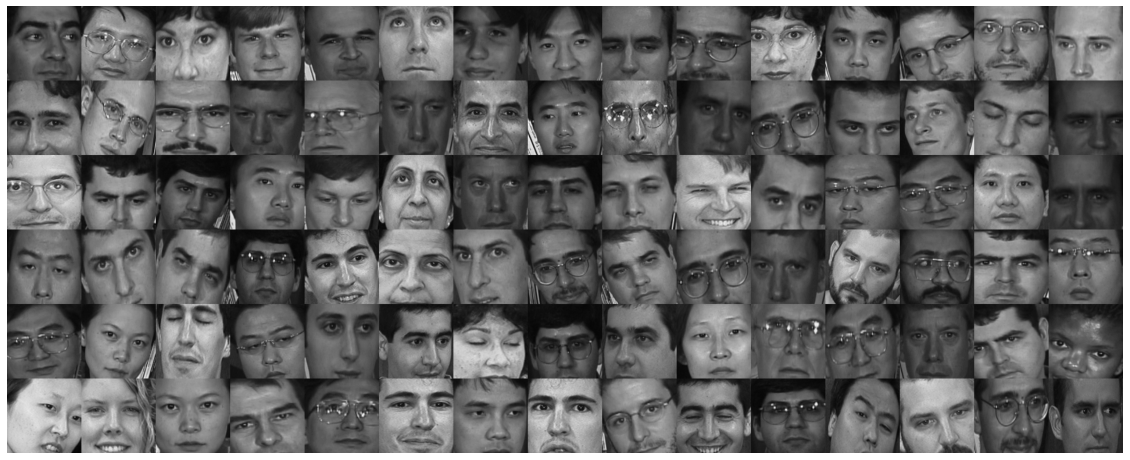

In [25]:
saveImgPath = './TrainTestImagesRes/ColorizingComb-'
savePathtrain = saveImgPath+'train-'
train_loss = 0.0
for i, data in enumerate(trainLoaderWithPredAB, 0):
    #print(data)
    # get the inputs; data is a list of [inputs, labels]
    #inputs, labels = data[0].to(device), data[1].to(device)
    inputs, labels = data[0].cuda(), data[2].cuda() #Color
    
    outputs = netClo(inputs)
    loss = criterion(outputs, labels)

    # print statistics
    train_loss += loss.item()
    saveRes2Img(inputs, labels, outputs,savePathtrain) 
    break
logStr = 'Train MSE_Loss: %.10f' % (train_loss/ (i+1))
print(logStr)

Test MSE of the network on the 75 test samples: 0.0003797293


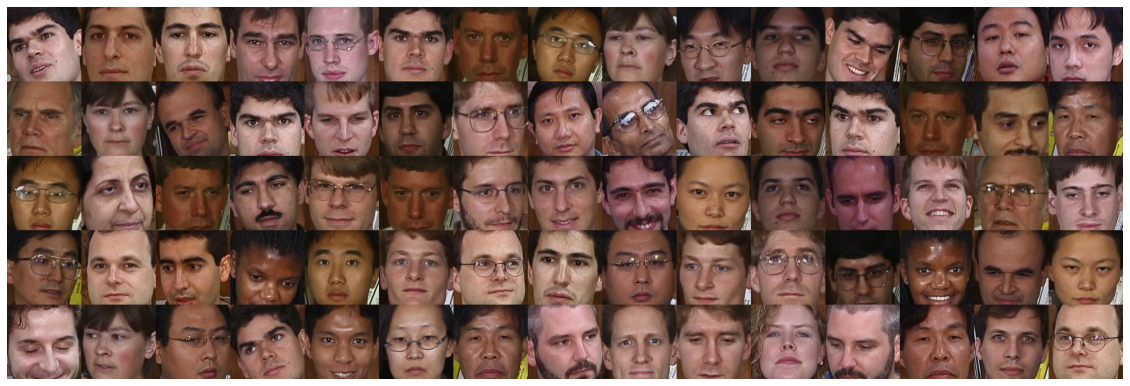

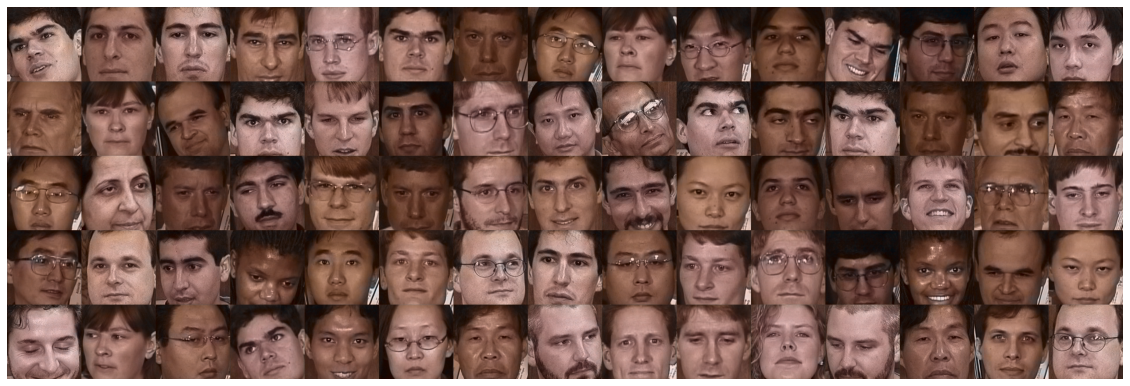

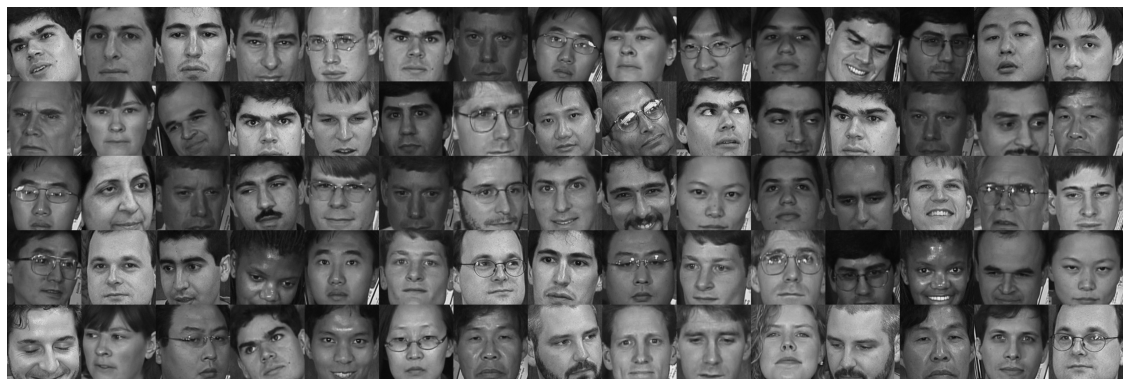

In [28]:
savePathtest = saveImgPath+'test-'
test_loss = 0
for i, data in enumerate(testLoaderWithPredAB, 0):
    inputs, labels = data[0].cuda(), data[2].cuda() #Color
    outputs = netClo(inputs)

    loss = criterion(outputs, labels)
    test_loss += loss.item()
    saveRes2Img(inputs, labels, outputs,savePathtest) 
n_samples = (i+1)*len(outputs)       

logStr = 'Test MSE of the network on the %d test samples: %.10f' % (n_samples, test_loss/(i+1))
print(logStr)
